A good reality TV show needs a variety of interesting archetypes. The Amazing Race, which first aired in 2001, is airing its 36th season in March 2024. Throughout its long history, there have been a lot of different teams from various backgrounds and with various relationships with one another. The aim of this project is to find out what are the underlying team archetypes in the Amazing Race. To achieve this, we use the team biographies from the Amazing Race Wiki. 

# Reading the data

We have scraped the data from the Amazing Race Wiki using the biographies from each of the team's page. Words in bold and italics have been remove as they correspond to the different questions that the teams were asked and the citation information. 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/bios.csv')

In [3]:
df.head()

,team_name,team_bio
0,Aaron & Arianne,\n“”\n\nBioQ & A\nAaron and Arianne have been ...
1,Aastha & Nina,"[1]\nAastha Lal and Nina Duong, engaged from M..."
2,Abbie & Ryan,"[1]\nAbbie[] 31\n Encinitas, Calif.\n Dating D..."
3,Abby & Will,"[1]\nAbby Garrett and Will Freeman, childhood ..."
4,Adam & Bethany,"[2]\nAdam[] 26\n Princeville, Hawaii\n Husband..."


To process the texts, we will first lemmatize each of the words. This will group words like "culture" and "cultures" together. 

In [4]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize         
from nltk.corpus import wordnet
from nltk.tag import pos_tag

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [312]:
# lemmatize the team bios
wnl = WordNetLemmatizer()
X = [' '.join([wnl.lemmatize(t[0], get_wordnet_pos(t[1])) 
               for t in pos_tag(word_tokenize(bio))]) 
               for bio in df['team_bio']]

# Getting the text statistics

In order to analyze the teams' biographies, we need to turn the texts into something we can numerically analyze. We will get the tf-idf (term frequency-inverse document frequency) and tf (term frequency) statistics for each word in each biography. We can then feed this information to three different types of models. We will feed the tf-idf information into a k-means model and a NMF (non-negative matrix factorization) model, and we will feed the tf information into a LDA (latent Dirichlet allocation) model.

In [313]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, 
                                   min_df=5,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

tf_vectorizer = CountVectorizer(max_df=0.5,
                                min_df=5,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(X)
tf_feature_names = tf_vectorizer.get_feature_names_out()

# k-means

The team biographies can now be viewed as a vector in high dimensional space. We can reduce the rank by extracting the most important components. Then the k-means algorithm will be applies to match similar team biographies together. 

In [314]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

In [315]:
print(f'''
The tf-idf matrix has dimensions {tfidf.shape} with {tfidf.nnz/np.prod(tfidf.shape):.2%} nonzero entries.
The rank-reduced matrix has dimensions {X_lsa.shape} that explains {explained_variance:.2%} of the variance.
'''
)


The tf-idf matrix has dimensions (363, 1893) with 5.09% nonzero entries.
The rank-reduced matrix has dimensions (363, 100) that explains 50.34% of the variance.



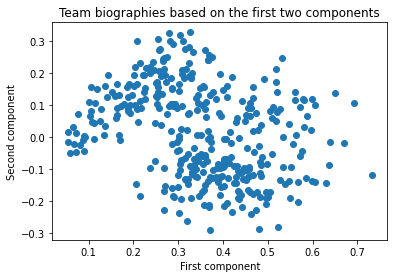

In [316]:
plt.scatter(X_lsa[:,0], X_lsa[:,1])
plt.xlabel("First component")
plt.ylabel("Second component")
plt.title("Team biographies based on the first two components")
plt.show()

Let's see what the first two components correspond to.

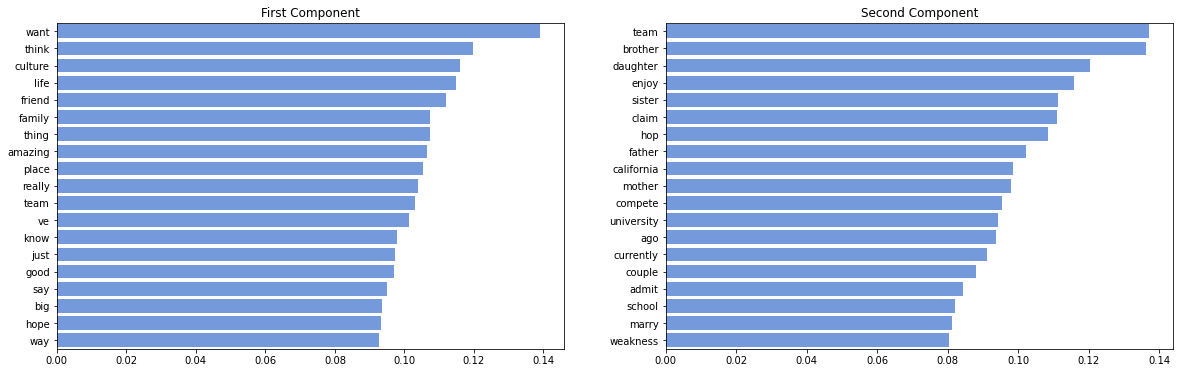

In [317]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))
for i in range(2):
    top_indices = lsa[0].components_[i].argsort()[:-20:-1]
    feat_names = [tfidf_feature_names[j] for j in top_indices]
    coeffs = [lsa[0].components_[i][j] for j in top_indices]
    sns.barplot(y=feat_names, x=coeffs, ax=axs[i], color="#6495ED")
    if i == 0:
        axs[i].set_title("First Component")
    else:
        axs[i].set_title("Second Component")
plt.show()

There is no clear interpretation what the components correspond to. The first component seems to be more focused on the experience, whereas the second components seems to be more focused on relationships. 

In [296]:
from sklearn.cluster import KMeans

In [321]:
# create k-means models for 2, 3, ..., 7 clusters
kmeans_models = []
for i in range(2, 8):
    kmeans = KMeans(
        n_clusters=i,
        max_iter=100,
        n_init=30,
        random_state=20
    )
    kmeans.fit(X_lsa)

    kmeans_models.append(kmeans)

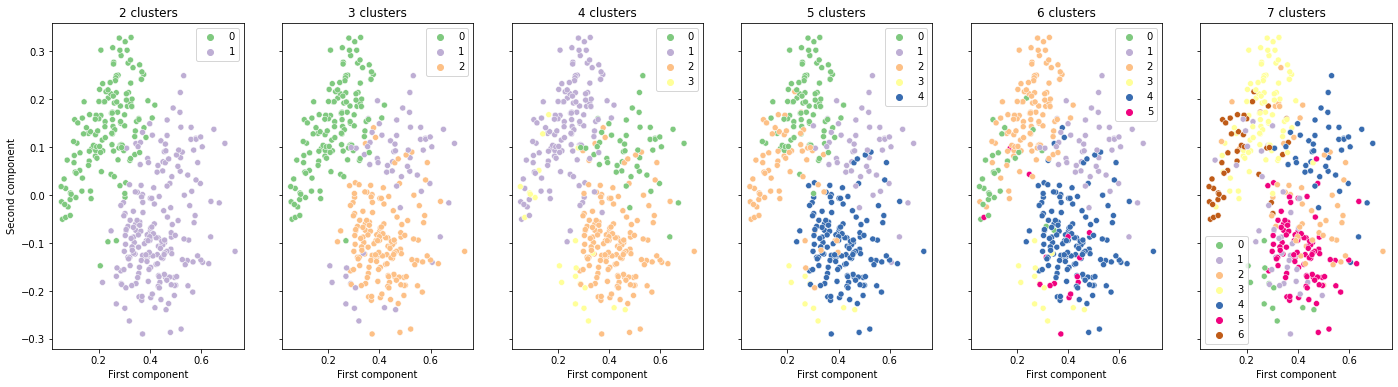

In [322]:
fig, axs = plt.subplots(1, 6, figsize=(24, 6), sharey=True)
for i in range(6): 
    kmeans = kmeans_models[i]

    sns.scatterplot(x=X_lsa[:,0], y=X_lsa[:,1], 
                    hue=kmeans.labels_, ax=axs[i],
                    palette='Accent')
    axs[i].set_xlabel("First component")
    axs[i].set_ylabel("Second component")
    axs[i].set_title(f"{i+2} clusters")
plt.show()

Qualitatively, starting at around 5 clusters, the clusters start to run into each other. However, we have to keep in mind that these scatterplots are only a projection onto the first two components, which will show more overlap than there is actually. 

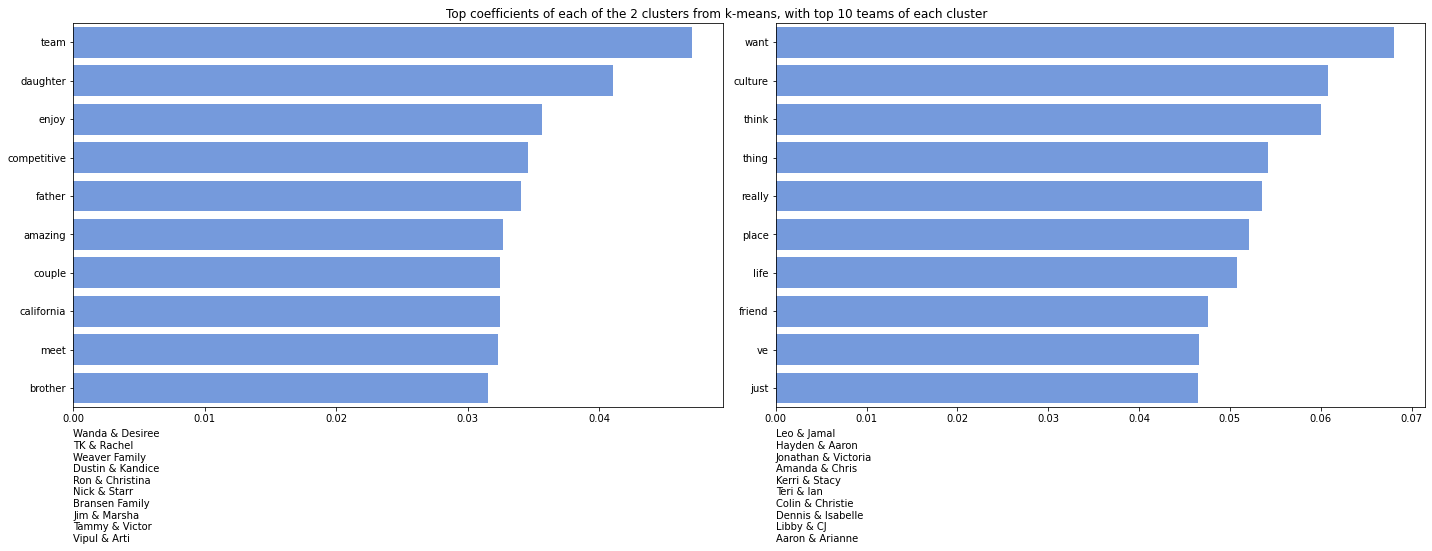

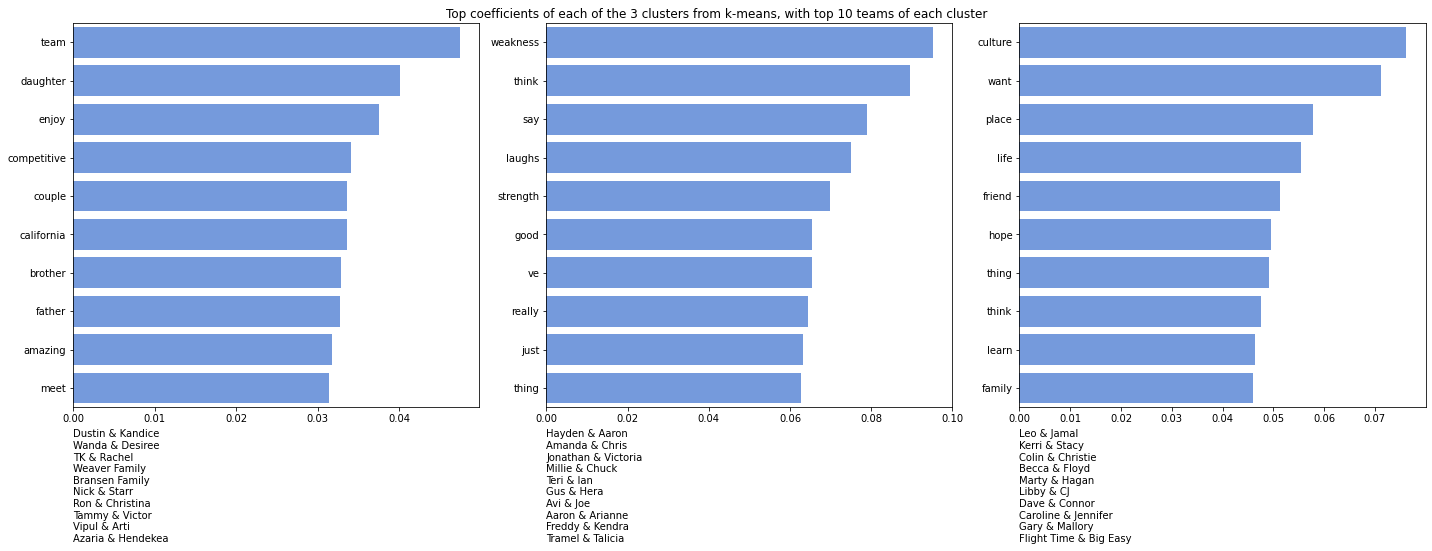

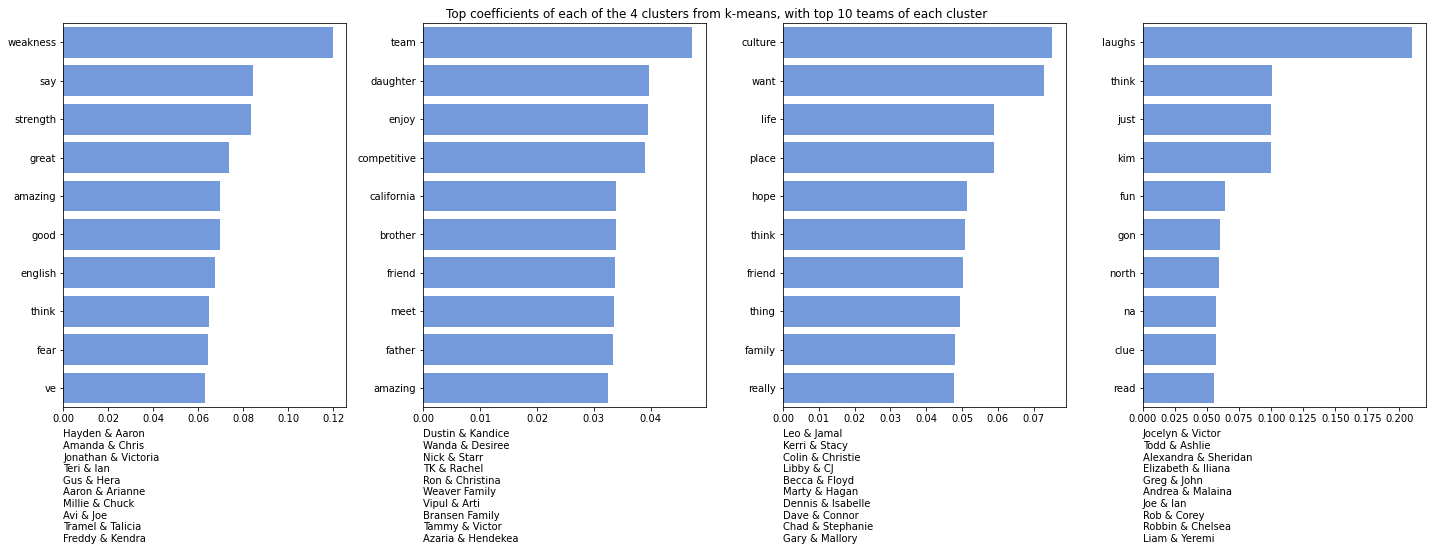

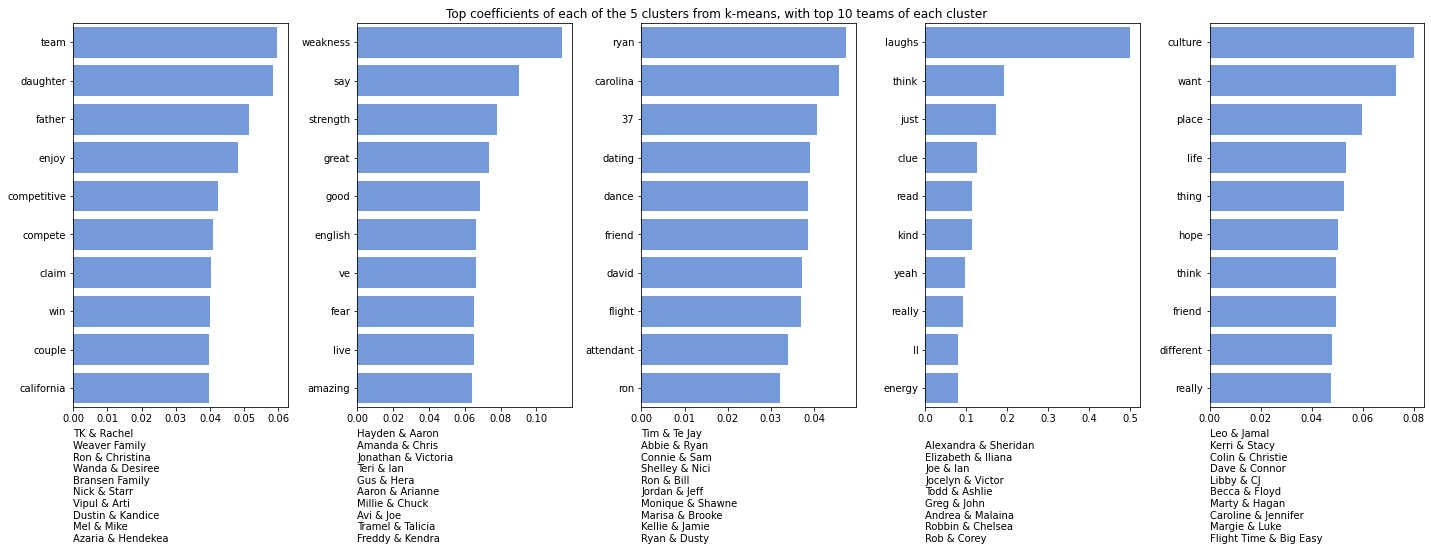

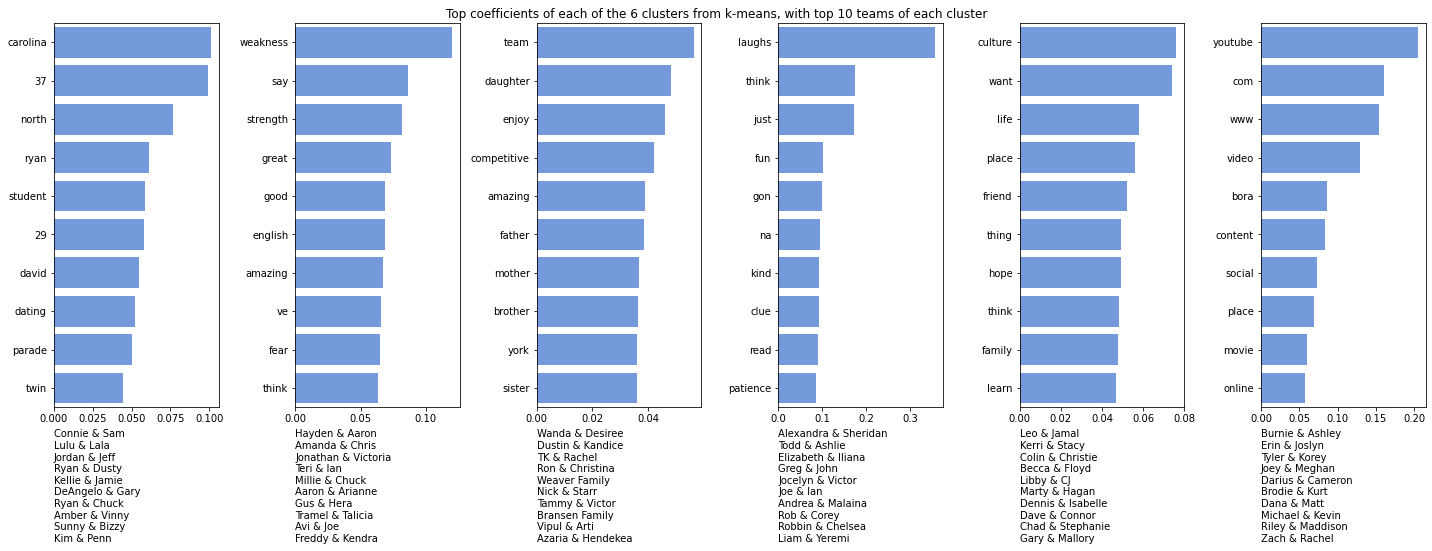

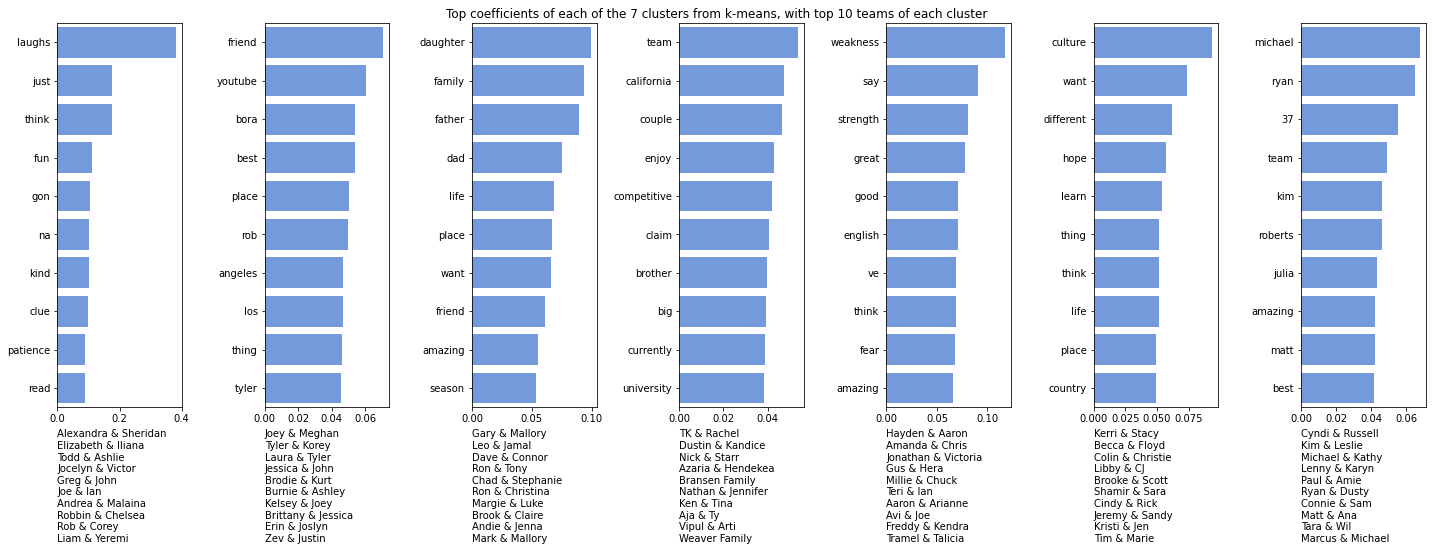

In [383]:
for i in range(6):
    kmeans = kmeans_models[i]
    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    tfidf_top_coeffs = np.sort(original_space_centroids)[:,:-11:-1]
    fig, axs = plt.subplots(1, i+2, figsize=(20,8))

    # organize information about distance to cluster centers 
    cluster_df = df.copy()
    cluster_df['cluster'] = kmeans.labels_
    dists = kmeans.fit_transform(X_lsa)
    for j in range(dists.shape[1]):
        cluster_df[f'dist_to_center{j}'] = dists[:,j]

    for j in range(i+2):
        top_terms = [terms[ind] for ind in order_centroids[j, :10]]
        sns.barplot(y=top_terms, x= tfidf_top_coeffs[j], ax=axs[j], color="#6495ED")

        top_cluster_teams = '\n'.join(cluster_df[cluster_df['cluster'] == j].nsmallest(10, f'dist_to_center{j}')['team_name'])
        axs[j].text(0,13,top_cluster_teams)
        axs[j].set_title(" ")

    plt.tight_layout()
    fig.suptitle(f'Top coefficients of each of the {i+2} clusters from k-means, with top 10 teams of each cluster')
    plt.show()

It looks like the best clusters come from 6 clusters in this case. There's a rough interpretation of the clusters as follows:

Cluster 1 - noise

Cluster 2 - noise

Cluster 3 - competitive family teams

Cluster 4 - noise from how the Season 35 interviews were transcribed

Cluster 5 - teams who want to see new places and cultures

Cluster 6 - internet personalities

# NMF

The Non-negative Matrix Factorization (NMF) algorithm will factor the tf-idf matrix into two matrices that correspond to a matrix of topics and a matrix of the percentage composition of the topics in each team biography. 

In [337]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF

In [338]:
# normalizing the tf-idf matrix
tfidf_norm = normalize(tfidf, norm='l1', axis=1)

In [391]:
nmfs = []

for i in range(2, 10):
    nmf = NMF(n_components=i, 
            random_state=20, 
            l1_ratio=.5, 
            init='nndsvd')
    
    nmfs.append(nmf)

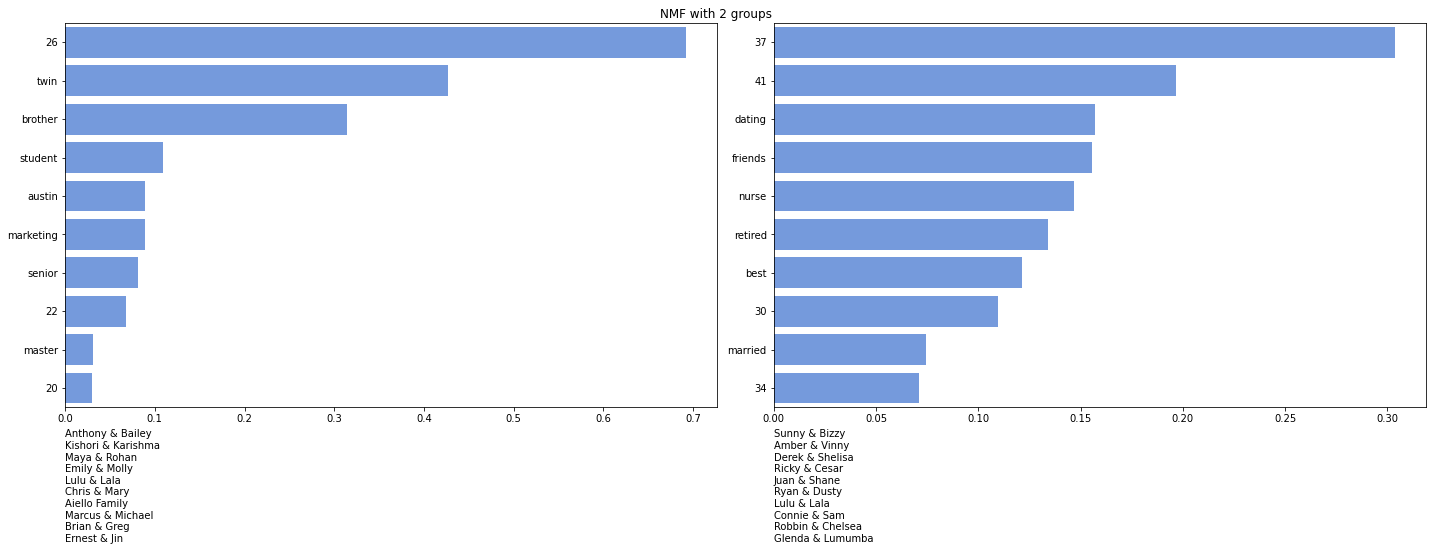

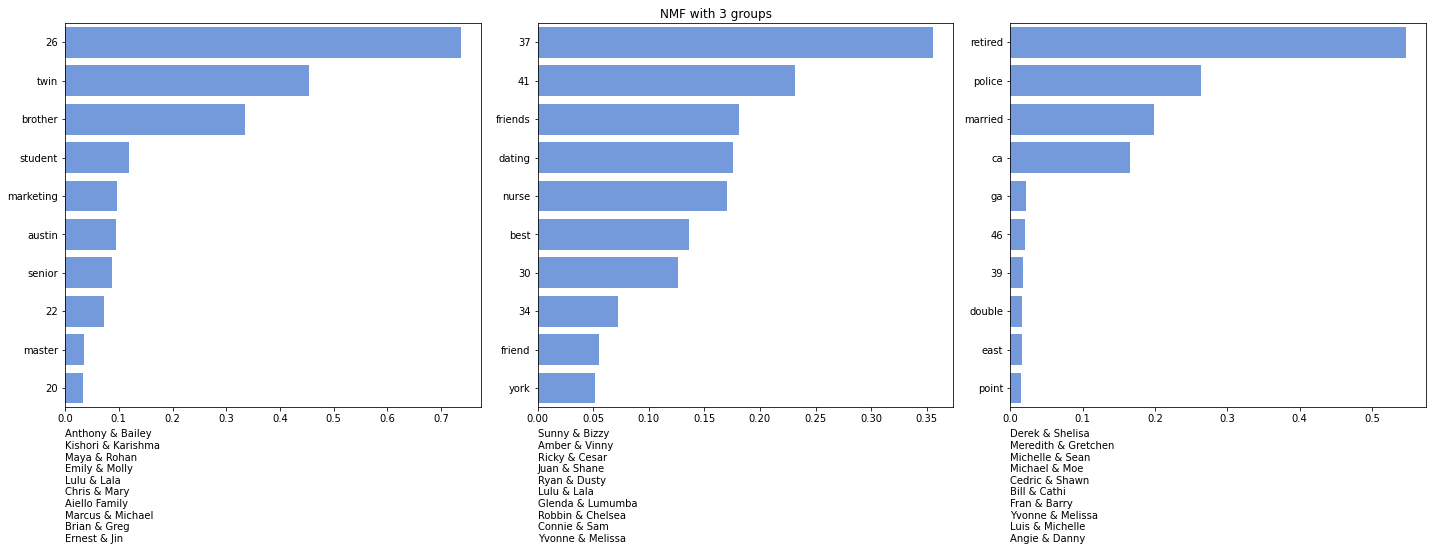

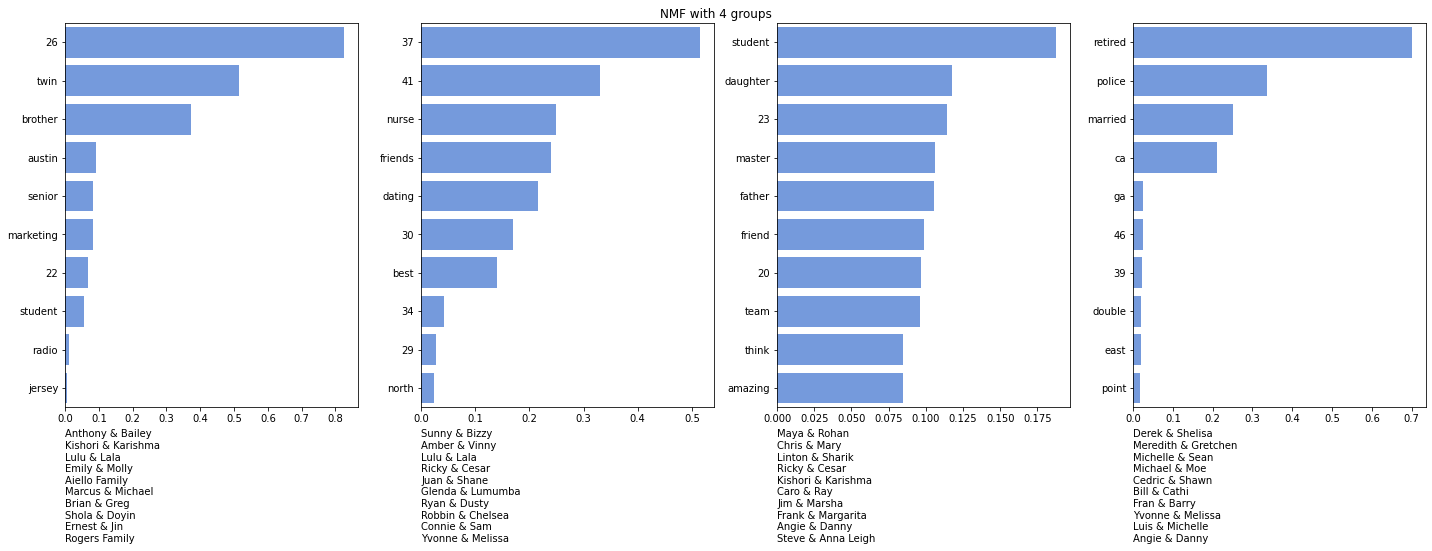

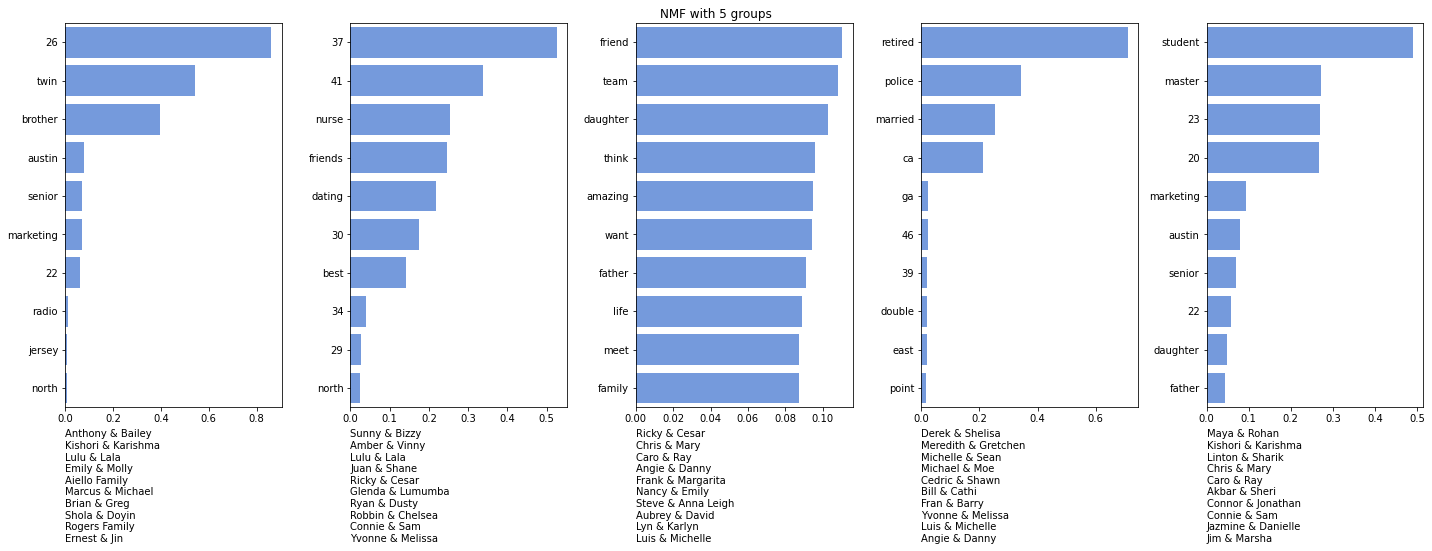

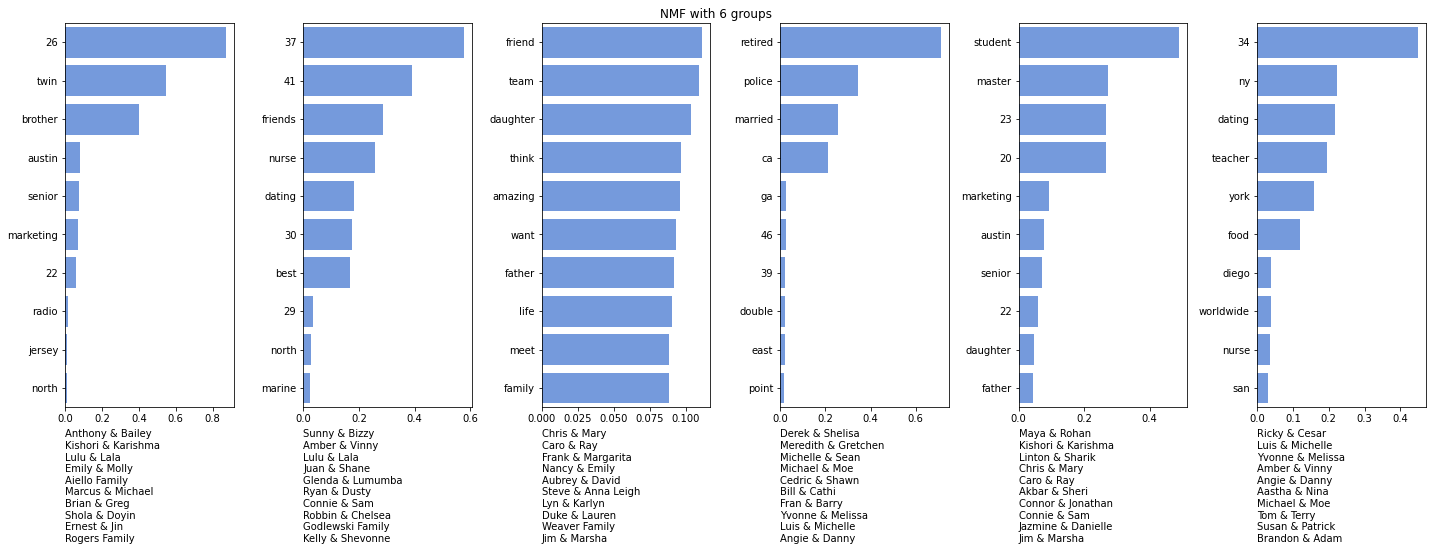

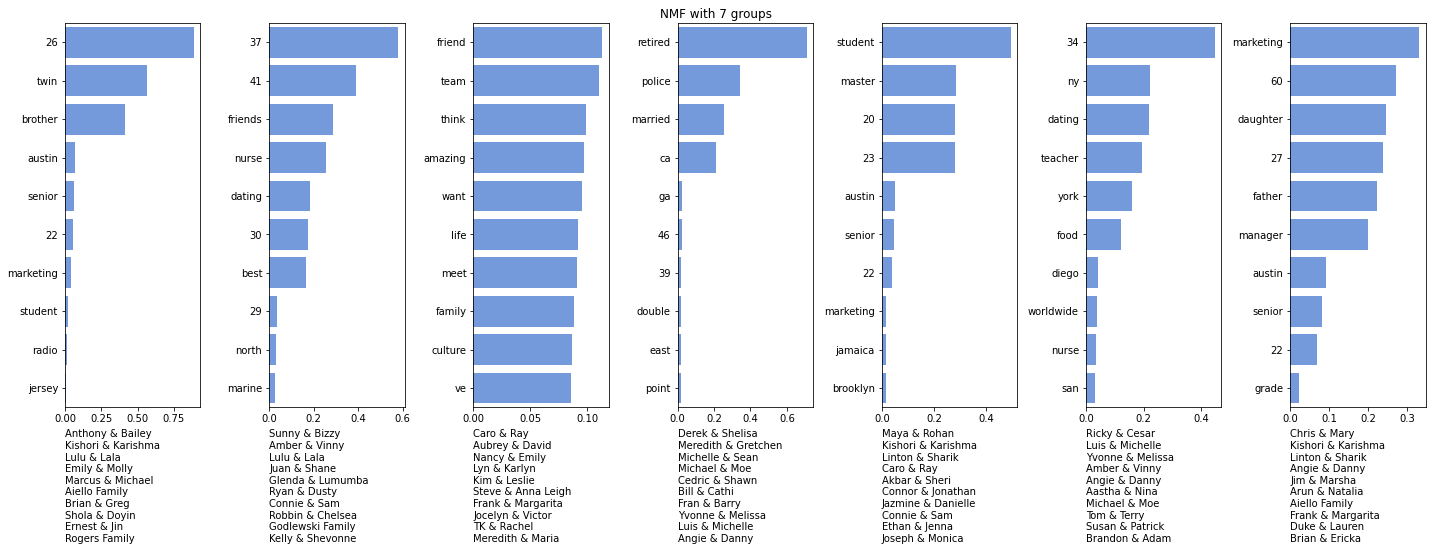

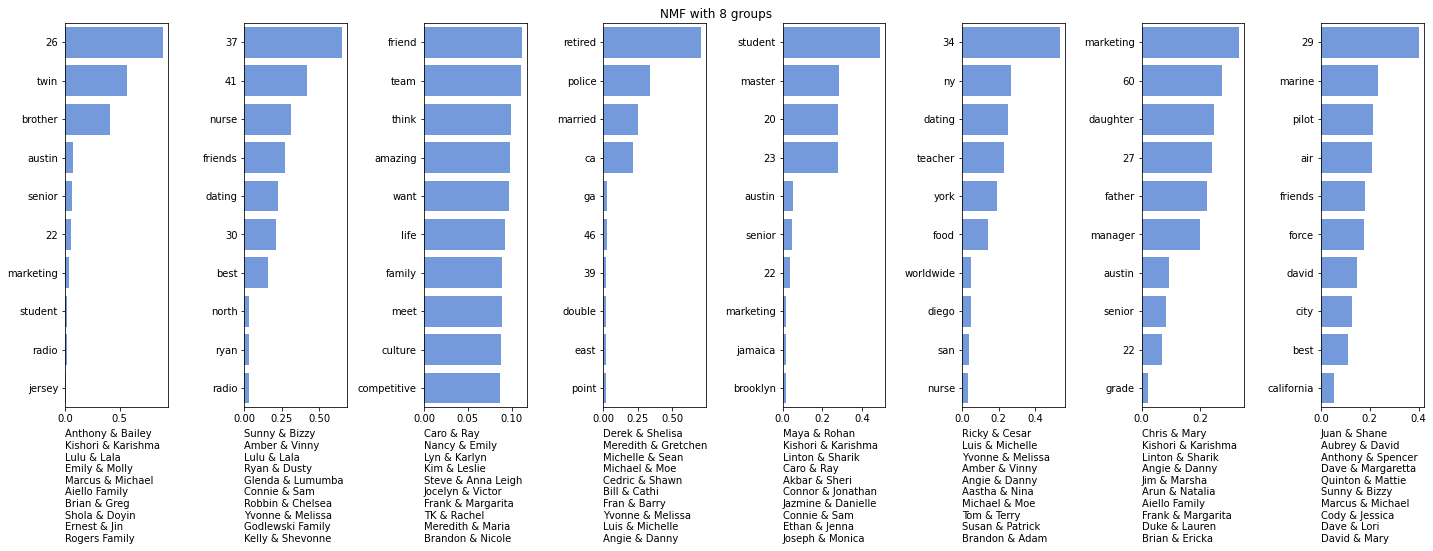

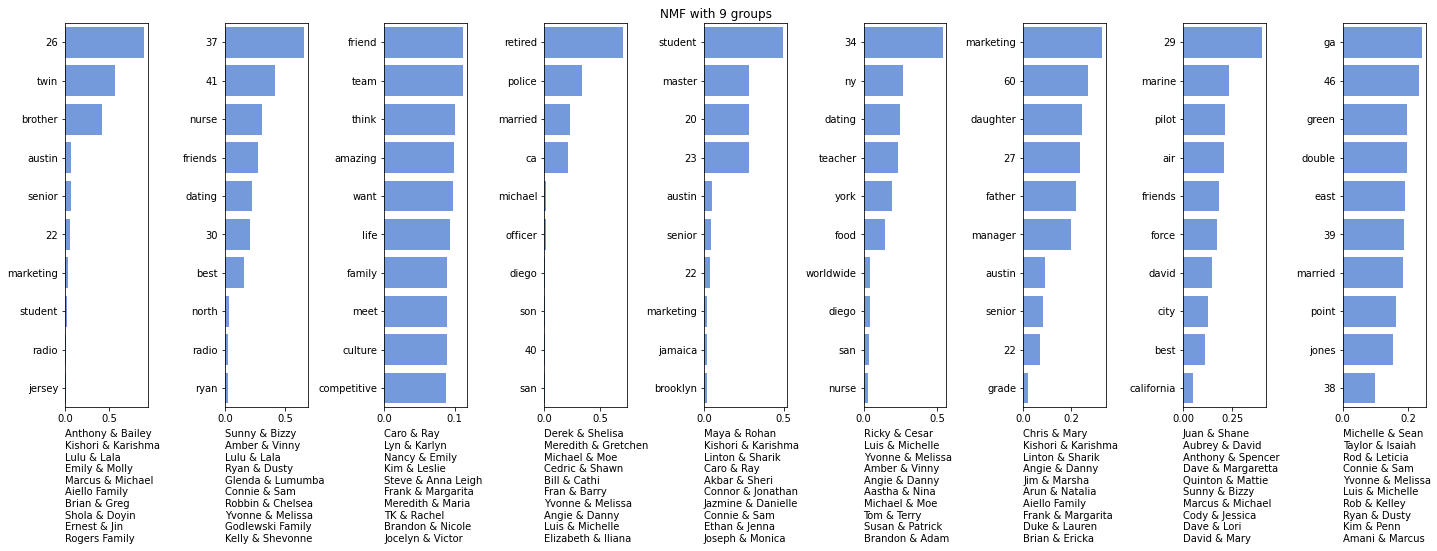

In [392]:
for i in range(8):
    nmf = nmfs[i]
    nmf_W = nmf.fit_transform(tfidf_norm)
    nmf_H = nmf.components_

    fig, axs = plt.subplots(1, i+2, figsize=(20,8))
    for cluster_num, topic_vect in enumerate(nmf_H):

        top_words_inds = topic_vect.argsort()[:-11:-1]
        top_team_inds = nmf_W[:,cluster_num].argsort()[:-11:-1]

        top_teams_in_cluster = '\n'.join(df['team_name'][top_team_inds].values)

        sns.barplot(y=tfidf_feature_names[top_words_inds],
                    x=topic_vect[top_words_inds],
                    ax=axs[cluster_num],
                    color="#6495ED")
        axs[cluster_num].set_title(f" ")
        axs[cluster_num].text(0, 13, top_teams_in_cluster)

    plt.tight_layout()
    plt.suptitle(f"NMF with {i+2} groups")
    plt.show()
    

For the NMF algorithm, the best grouping of teams is at the one with 8 groups. We can roughly interpret these groups:

Group 1 - Twins/siblings in their 20s

Group 2 - Friends/dating in their 30s

Group 3 - Competitive friend/family teams who want to experience other cultures

Group 4 - Retired married couples and police officers

Group 5 - Students in their 20s

Group 6 - Dating teams

Group 7 - Parent/child teams

Group 8 - Military teams and Davids

# LDA

The Latent Dirichlet allocation (LDA) algorithm uses Bayesian methods to estimate every word's contribution to a topic and the proportion of each topic present in each team biography.

In [324]:
from sklearn.decomposition import LatentDirichletAllocation

In [393]:
ldas = []

for i in range(2, 10):
    lda = LatentDirichletAllocation(n_components=i,
                                    max_iter=5, 
                                    learning_method='online', 
                                    learning_offset=50,
                                    random_state=20)
    
    ldas.append(lda)

In [394]:
# normalizing the tf matrix
tf_norm = normalize(tfidf, norm='l1', axis=1)

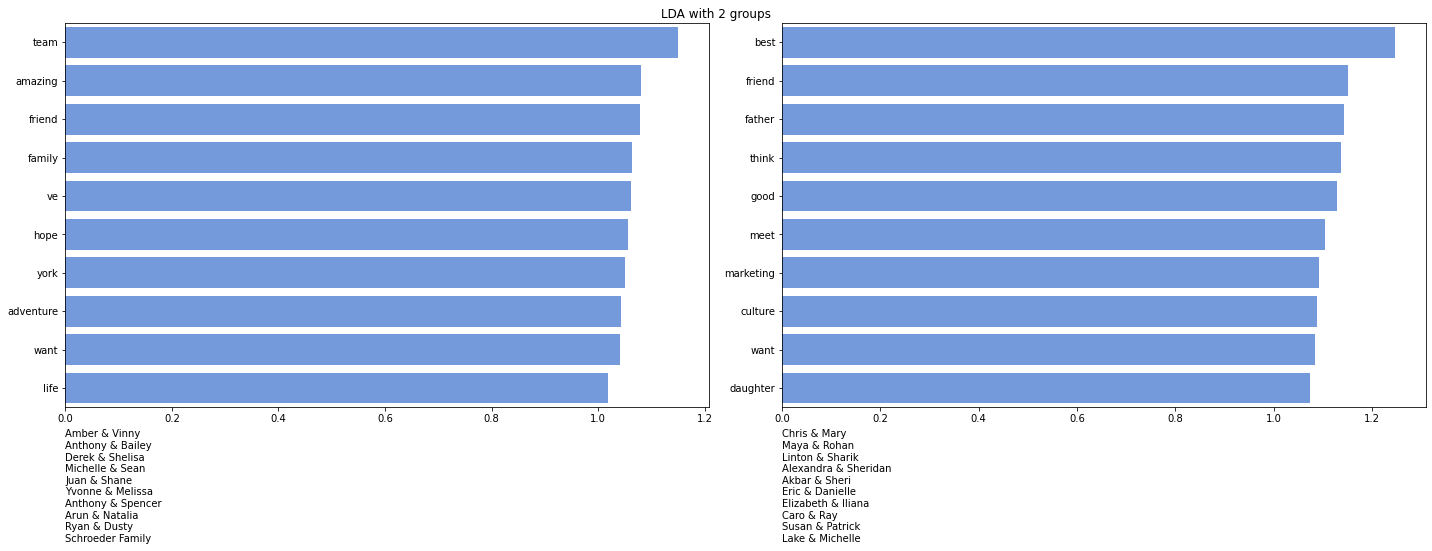

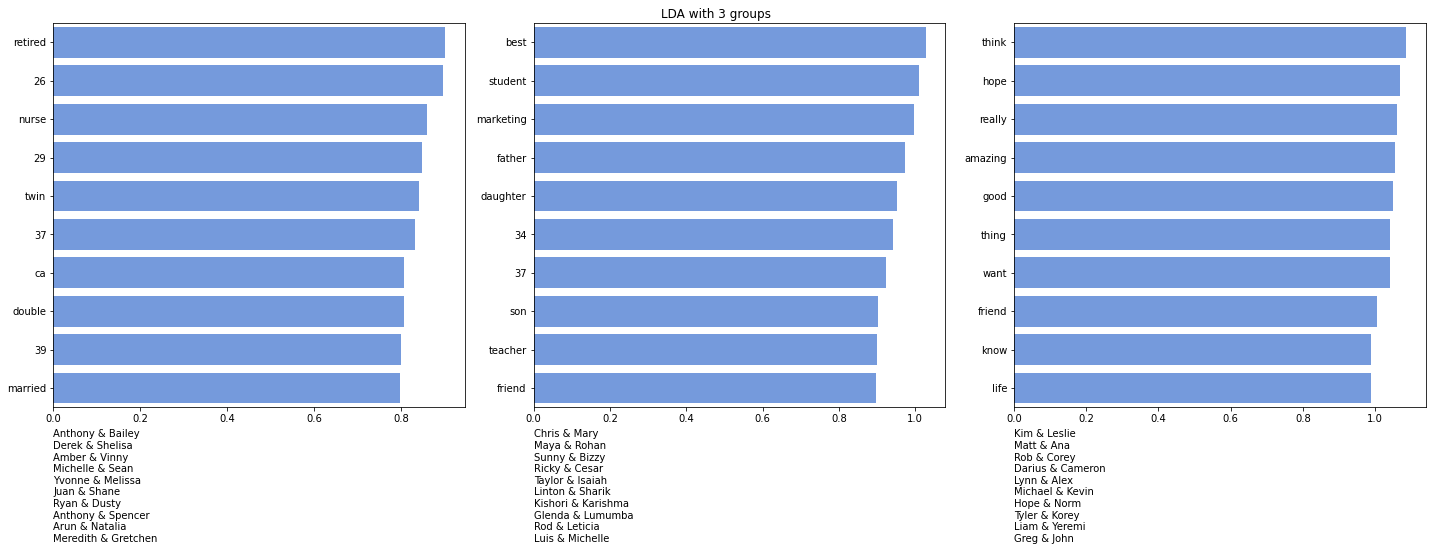

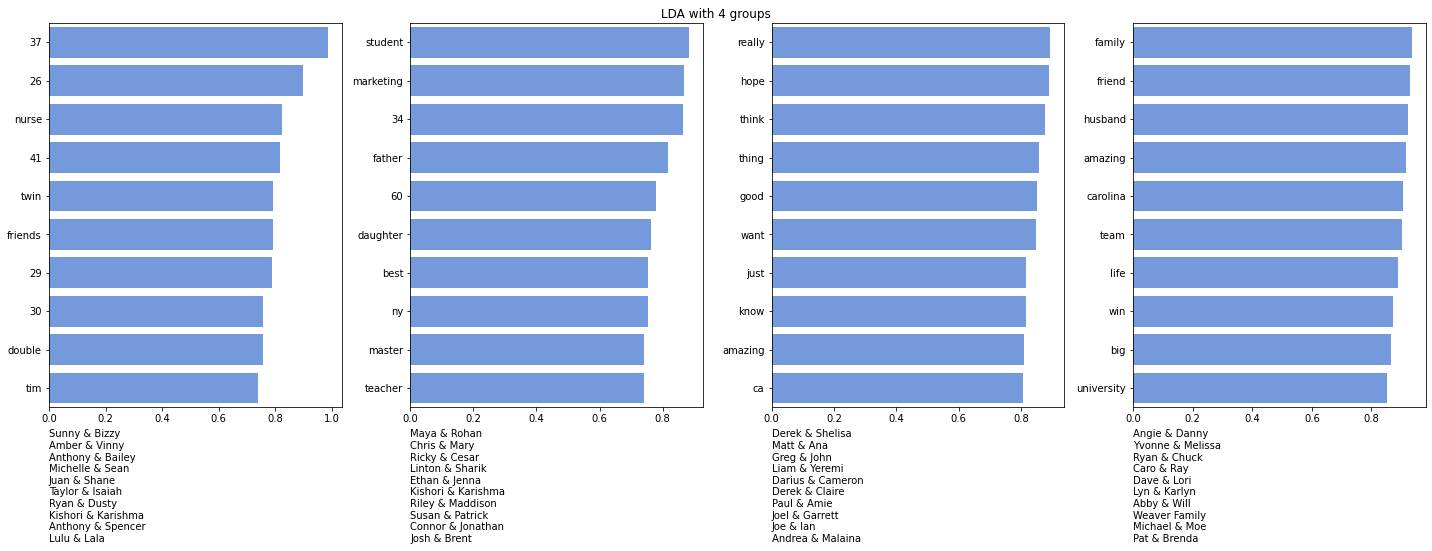

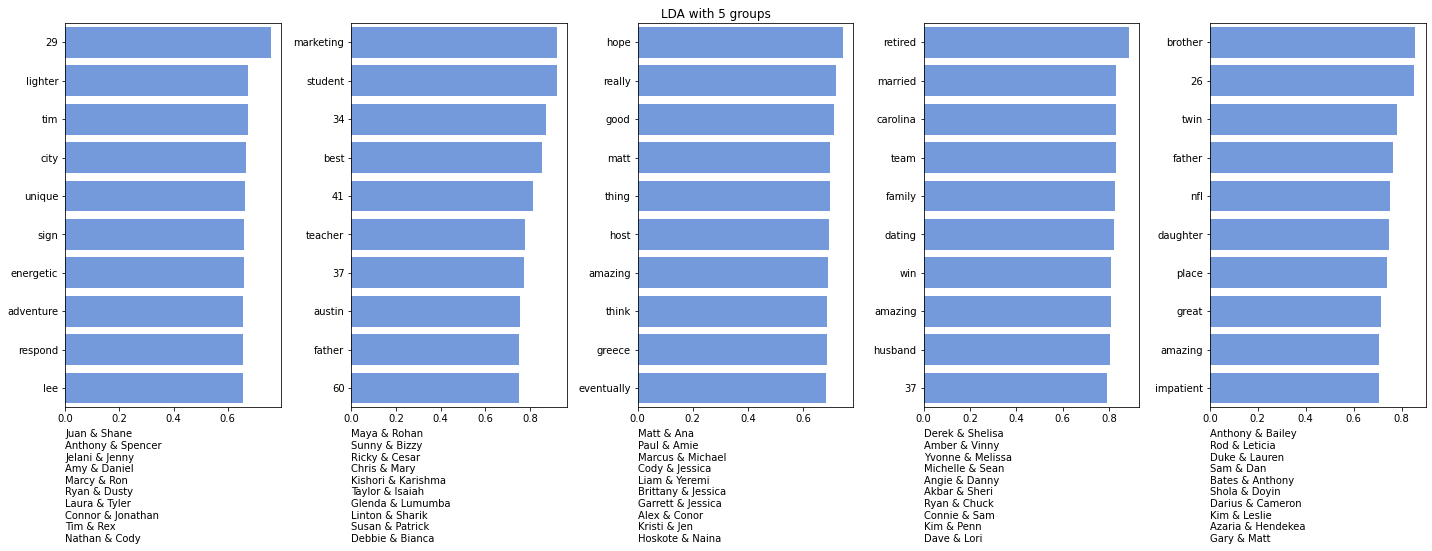

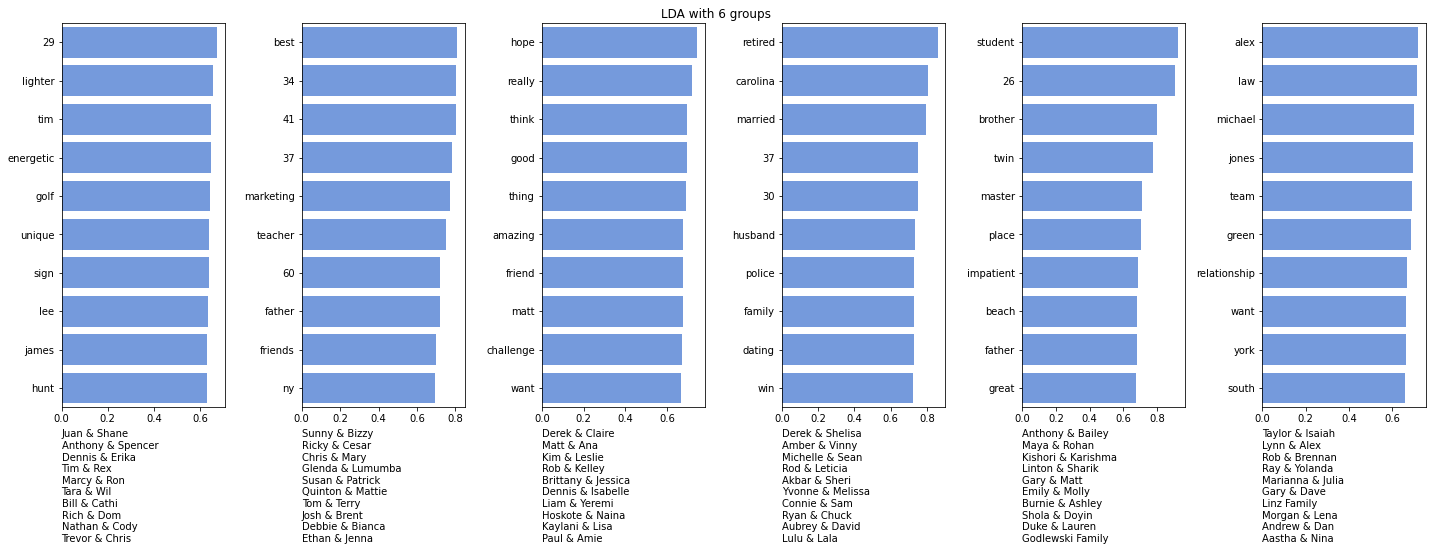

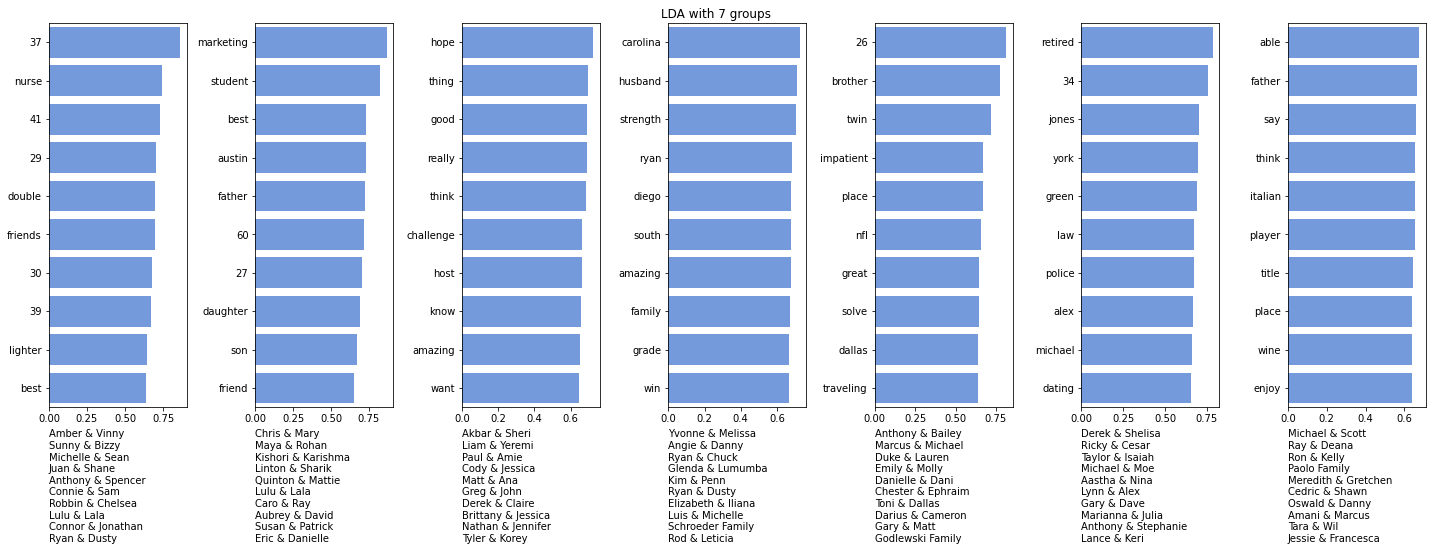

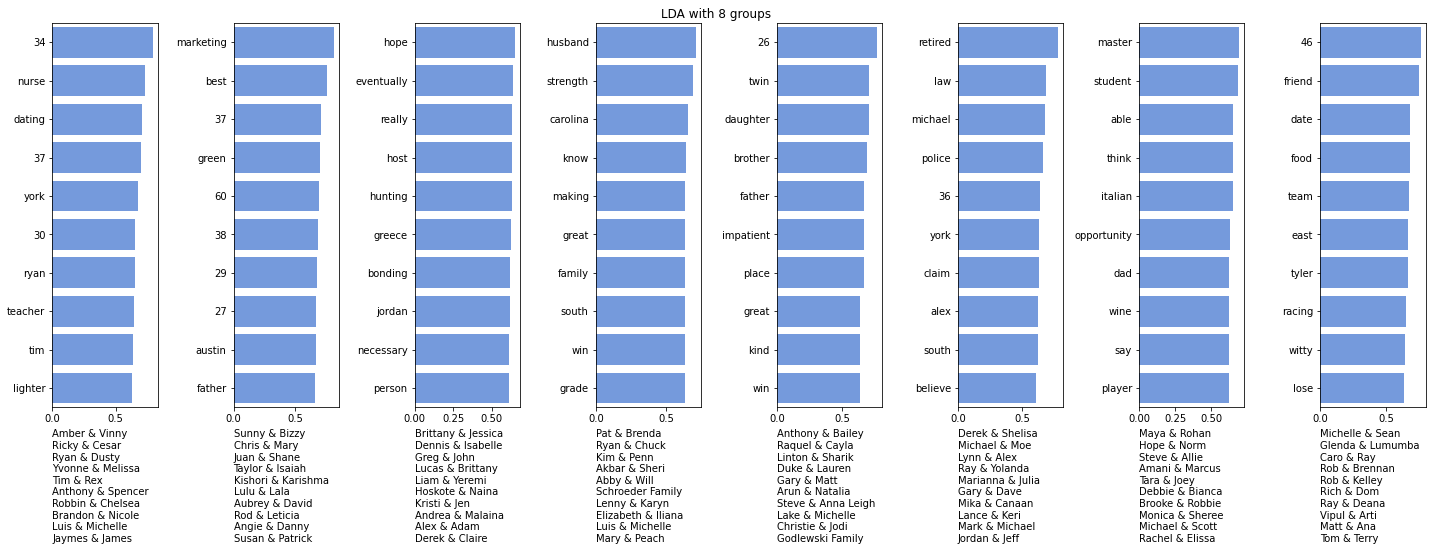

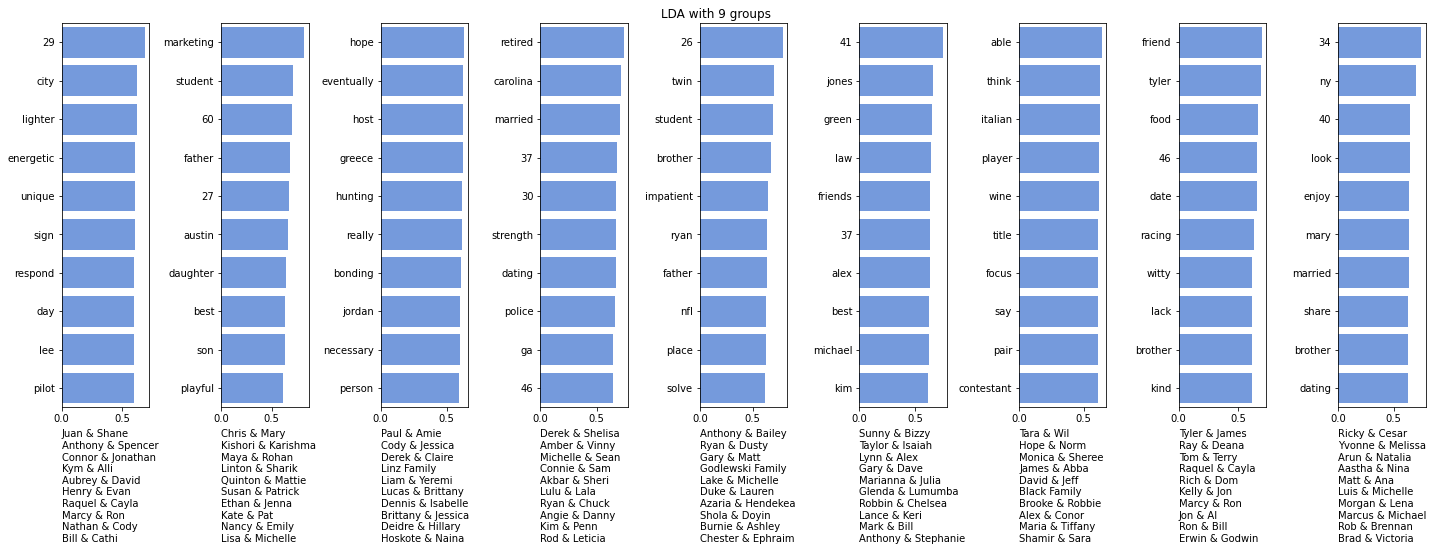

In [397]:
for i in range(8):
    lda = ldas[i]
    lda_W = lda.fit_transform(tf_norm)
    lda_H = lda.components_

    fig, axs = plt.subplots(1, i+2, figsize=(20,8))
    for cluster_num, topic_vect in enumerate(lda_H):

        top_words_inds = topic_vect.argsort()[:-11:-1]
        top_team_inds = lda_W[:,cluster_num].argsort()[:-11:-1]

        top_teams_in_cluster = '\n'.join(df['team_name'][top_team_inds].values)

        sns.barplot(y=tfidf_feature_names[top_words_inds],
                    x=topic_vect[top_words_inds],
                    ax=axs[cluster_num],
                    color="#6495ED")
        axs[cluster_num].set_title(f" ")
        axs[cluster_num].text(0, 13, top_teams_in_cluster)

    plt.tight_layout()
    plt.suptitle(f"LDA with {i+2} groups")
    plt.show()
    

There doesn't seem to be any good groupings here. 